In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')
spec = "human"
ST_name = "intestine5fold"
seed = 10
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
spa_adata = sc.read_h5ad("../../data/ST/intest/A1.h5ad")
spa_adata.obsm['spatial'] = spa_adata.obsm['spatial'][['x','y']].values
pd.DataFrame(spa_adata.obsm['spatial'], columns=['x','y']).to_csv(f"../../output/locations/{ST_name}.csv", index=False)
rna_adata = sc.read_csv("../../data/scRNAseq/intest/GSE125970_raw_UMIcounts.txt", '\t', first_column_names=True).T.copy()
rna_adata.obs = pd.read_csv("../../data/scRNAseq/intest/GSE125970_cell_info.txt", header=0, delimiter='\t', index_col=0).loc[rna_adata.obs_names]
rna_adata, spa_adata

(AnnData object with n_obs × n_vars = 14537 × 19525
     obs: 'Sample_ID', 'CellType',
 AnnData object with n_obs × n_vars = 2649 × 33538
     obs: 'Colonocytes', 'Crypt Top Colonocytes', 'Goblets', 'Undifferentiated', 'BEST4+/OTOP2+ Cell', 'Enteroendocrines', 'Glial', 'Stromal 2', 'Stromal 3', 'Stromal 1', 'Endothelial 1', 'Endothelial 2', 'Myofibroblasts', 'Stromal 4', 'Pericytes', 'ILCs', 'T-Cells', 'Macrophages&Monocytes', 'DC2', 'DC1', 'NK', 'Mast Cells', 'Cycling Cells', 'B-Cells', 'Plasma Cells'
     obsm: 'spatial')

In [3]:
classes, ct_list = leiden_cluster(rna_adata)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, coord_type="grid", n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.filter_genes(rna_adata, min_cells=10)
sc.pp.filter_genes(spa_adata, min_cells=3)
sc.pp.highly_variable_genes(spa_adata, n_top_genes=5000)
# rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sdm.extract_lr(spa_adata, spec, min_cell=0)
spa_genes = set()
for pair in spa_adata.uns['geneInter'].interaction_name:
    _genes = pair.split('_')
    for g in _genes:
        for _g in g.split(":"):
            spa_genes.add(_g)
for gene in spa_adata.uns['moranI'].index[spa_adata.uns['moranI'].pval_norm_fdr_bh <= 0.01].values:
    spa_genes.add(gene)

for gene in spa_adata.var_names[spa_adata.var.highly_variable]:    
    spa_genes.add(gene)
      
print(len(np.intersect1d(list(spa_genes), spa_adata.var_names)), len(spa_genes), spa_adata.n_vars)
spa_adata = spa_adata[:, np.intersect1d(list(spa_genes), spa_adata.var_names)]
rna_adata, spa_adata

8227 8297 16953


(AnnData object with n_obs × n_vars = 14537 × 17416
     obs: 'Sample_ID', 'CellType', 'leiden'
     var: 'n_cells'
     uns: 'log1p',
 View of AnnData object with n_obs × n_vars = 2649 × 8227
     obs: 'Colonocytes', 'Crypt Top Colonocytes', 'Goblets', 'Undifferentiated', 'BEST4+/OTOP2+ Cell', 'Enteroendocrines', 'Glial', 'Stromal 2', 'Stromal 3', 'Stromal 1', 'Endothelial 1', 'Endothelial 2', 'Myofibroblasts', 'Stromal 4', 'Pericytes', 'ILCs', 'T-Cells', 'Macrophages&Monocytes', 'DC2', 'DC1', 'NK', 'Mast Cells', 'Cycling Cells', 'B-Cells', 'Plasma Cells'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial_neighbors', 'moranI', 'hvg', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [4]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2649, 8227), (14537, 17416), (6852,))

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        clip_max=0.5,
        n_epochs=2000,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

    df_transImpCls[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

    df_transImp[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                clip_max=0.5,
                n_epochs=2000,
                seed=seed,
                device=device)
    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "4546564", top_k=2000, verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImp_res), "(TransImp)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
      )


===== Fold 1 =====
Number of train genes: 5481, Number of test genes: 1371


[TransImp] Epoch: 2000/2000, loss: 1.066549, (IMP) 1.065697, (SPA) 1.0 x 0.000852: 100%|██████████| 2000/2000 [00:36<00:00, 55.12it/s]


Median correlation: 0.11326760783689417 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.018480, (IMP) 1.018480, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 160.43it/s]


Median correlation: 0.16306641810849515 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.050420, (IMP) 1.050420, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:26<00:00, 74.14it/s]


Median correlation: 0.1586852018336714 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.035409, (IMP) 1.030785, (SPA) 1.0 x 0.004624: 100%|██████████| 2000/2000 [00:21<00:00, 94.29it/s]


Median correlation: 0.14025859457802858 (TransImpClsSpa)
			nan (stPlus)
			0.10824059462828979 (spaGE)


INFO:root:5481 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5481 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5481 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.266, KL reg: 0.104
Score: 0.321, KL reg: 0.000
Score: 0.322, KL reg: 0.000
Score: 0.322, KL reg: 0.000
Score: 0.323, KL reg: 0.000
Score: 0.323, KL reg: 0.000
Score: 0.323, KL reg: 0.000
Score: 0.323, KL reg: 0.000
Score: 0.323, KL reg: 0.000
Score: 0.323, KL reg: 0.000


INFO:root:Saving results..


			0.1588079979840111 (Tangram)

===== Fold 2 =====
Number of train genes: 5481, Number of test genes: 1371


[TransImp] Epoch: 2000/2000, loss: 1.040155, (IMP) 1.039716, (SPA) 1.0 x 0.000440: 100%|██████████| 2000/2000 [00:35<00:00, 56.65it/s]


Median correlation: 0.10329648815208407 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.990642, (IMP) 0.990642, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 162.23it/s]


Median correlation: 0.16165211991486272 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.023107, (IMP) 1.023107, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:26<00:00, 74.58it/s]


Median correlation: 0.15949358719741427 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.007529, (IMP) 1.002747, (SPA) 1.0 x 0.004781: 100%|██████████| 2000/2000 [00:20<00:00, 95.37it/s]


Median correlation: 0.1372226623259165 (TransImpClsSpa)
			nan (stPlus)
			0.10402152584949512 (spaGE)


INFO:root:5481 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5481 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5481 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.268, KL reg: 0.101
Score: 0.322, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000


INFO:root:Saving results..


			0.15911723661919208 (Tangram)

===== Fold 3 =====
Number of train genes: 5482, Number of test genes: 1370


[TransImp] Epoch: 2000/2000, loss: 1.045070, (IMP) 1.044620, (SPA) 1.0 x 0.000449: 100%|██████████| 2000/2000 [00:35<00:00, 56.62it/s]


Median correlation: 0.10104352106951629 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.995733, (IMP) 0.995733, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 160.09it/s]


Median correlation: 0.15828559619403682 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.028161, (IMP) 1.028161, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:26<00:00, 74.45it/s]


Median correlation: 0.15839689999269632 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.012718, (IMP) 1.007814, (SPA) 1.0 x 0.004903: 100%|██████████| 2000/2000 [00:20<00:00, 95.58it/s]


Median correlation: 0.13682210155716817 (TransImpClsSpa)
			nan (stPlus)
			0.10624774401383846 (spaGE)


INFO:root:5482 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5482 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5482 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.270, KL reg: 0.099
Score: 0.323, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.324, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000
Score: 0.325, KL reg: 0.000


INFO:root:Saving results..


			0.16051333552644972 (Tangram)

===== Fold 4 =====
Number of train genes: 5482, Number of test genes: 1370


[TransImp] Epoch: 2000/2000, loss: 1.057748, (IMP) 1.057414, (SPA) 1.0 x 0.000334: 100%|██████████| 2000/2000 [00:35<00:00, 56.29it/s]


Median correlation: 0.0962366421850065 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 1.007775, (IMP) 1.007775, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 160.82it/s]


Median correlation: 0.158616303698801 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.040041, (IMP) 1.040041, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:27<00:00, 73.91it/s]


Median correlation: 0.1576626542106978 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.024509, (IMP) 1.019930, (SPA) 1.0 x 0.004580: 100%|██████████| 2000/2000 [00:21<00:00, 93.89it/s]


Median correlation: 0.13459956356591224 (TransImpClsSpa)
			nan (stPlus)
			0.10782690348701568 (spaGE)


INFO:root:5482 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5482 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5482 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.272, KL reg: 0.099
Score: 0.325, KL reg: 0.000
Score: 0.326, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000


INFO:root:Saving results..


			0.15567358870608713 (Tangram)

===== Fold 5 =====
Number of train genes: 5482, Number of test genes: 1370


[TransImp] Epoch: 2000/2000, loss: 1.042835, (IMP) 1.042559, (SPA) 1.0 x 0.000276: 100%|██████████| 2000/2000 [00:35<00:00, 56.17it/s]


Median correlation: 0.09448562469668223 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.994225, (IMP) 0.994225, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 160.15it/s]


Median correlation: 0.15130978701908843 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 1.024739, (IMP) 1.024739, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:26<00:00, 74.08it/s]


Median correlation: 0.15310975468993737 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 1.011114, (IMP) 1.006328, (SPA) 1.0 x 0.004787: 100%|██████████| 2000/2000 [00:21<00:00, 94.32it/s]


Median correlation: 0.12901538796864148 (TransImpClsSpa)
			nan (stPlus)
			0.10123155321085048 (spaGE)


INFO:root:5482 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:5482 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 5482 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.272, KL reg: 0.099
Score: 0.325, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000
Score: 0.327, KL reg: 0.000


INFO:root:Saving results..


			0.15409085599624994 (Tangram)
0.10165315586526597 (TransImpSpa) 0.1575384758818995 (TransImp) 0.15855144088992126 (TransImpCls) 0.1362321346348213 (TransImpClsSpa) nan (stPlus) 0.10533465986748396 (spaGE) 0.1575730425915523 (Tangram)


In [6]:
df_transImp.to_csv(f'../../output/{ST_name}_{ST_name}_TransImp.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [7]:
dict_df = {
            "TransImp":df_transImp, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    genes=spa_adata.var_names,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


In [8]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImp: 0.238111
	True vs TransImpSpa: 0.003424
	True vs TransImpCls: 0.337256
	True vs TransImpClsSpa: 0.005046
	True vs spaGE: 0.154074
	True vs Tangram: 0.276690
	True vs truth: 0.000000


In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings

color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
methods = ['truth', 'Tangram', 'TransImp', 'TransImpSpa', 'spaGE', 'stPlus',  'TransImpCls', 'TransImpClsSpa']
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [10]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}, 'pval':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            genes=imp_adata.var_names,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['pval'][method] = pd.Series(imp_adata.uns['moranI'].pval_norm, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

100%|██████████| 8/8 [01:09<00:00,  8.75s/it]


In [11]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr

Tangram      TransImp   TransImpCls  TransImpClsSpa  \
A1BG    0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
A1CF    0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
AADAT   0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
AAED1   0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
AASDH   0.000000e+00  0.000000e+00  0.000000e+00    0.000000e+00   
...              ...           ...           ...             ...   
ZSWIM1  8.886972e-16  0.000000e+00  0.000000e+00    6.832002e-04   
ZSWIM4  1.950628e-12  0.000000e+00  0.000000e+00    5.217970e-04   
ZXDB    3.166170e-12  0.000000e+00  0.000000e+00    4.364866e-04   
ZYX     1.374387e-07  0.000000e+00  0.000000e+00    2.258332e-04   
ZZEF1   5.985679e-05  6.383782e-14  4.872900e-08    1.390826e-10   

         TransImpSpa     spaGE  stPlus     truth  
A1BG    0.000000e+00  0.000000     NaN  0.000036  
A1CF    0.000000e+00  0.000000     NaN  0.000057  
AADAT   0.000000e+00  0.000000     NaN  0.478667  
AAED1   0.000000e+00  0.000000     NaN  0.272210  
AASDH   0.000000e+00  0.000000     NaN  0.022143  
...              ...       ...     ...       ...  
ZSWIM1  8.505021e-07  0.191040     NaN  0.009604  
ZSWIM4  9.687180e-08  0.121650     NaN  0.328586  
ZXDB    9.513829e-08  0.118419     NaN  0.433941  
ZYX     7.620350e-09  0.112814     NaN  0.000000  
ZZEF1   9.669026e-14  0.013619     NaN  0.000007  

[6852 rows x 8 columns]

(Tangram) Valid genes: 5512/6852
0
Tangram
(Tangram) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
FPR: 1.000000
(TransImp) Valid genes: 5512/6852
0
TransImp
(TransImp) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5512/5512)
FPR: 1.000000
(TransImpSpa) Valid genes: 5512/6852
0
TransImpSpa
(TransImpSpa) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (3693/5512)
FPR: 0.676251
(spaGE) Valid genes: 5512/6852
0
spaGE
(spaGE) Valid genes: 5512/6852, Ground Sig/Total (3634/5512), Pred Sig/total (5437/5512)
FPR: 0.973376
(stPlus) Valid genes: 5351/6852
5351
stPlus
(stPlus) Valid genes: 5351/6852, Ground Sig/Total (3521/5351), Pred Sig/total (0/5351)
FPR: 0.000000


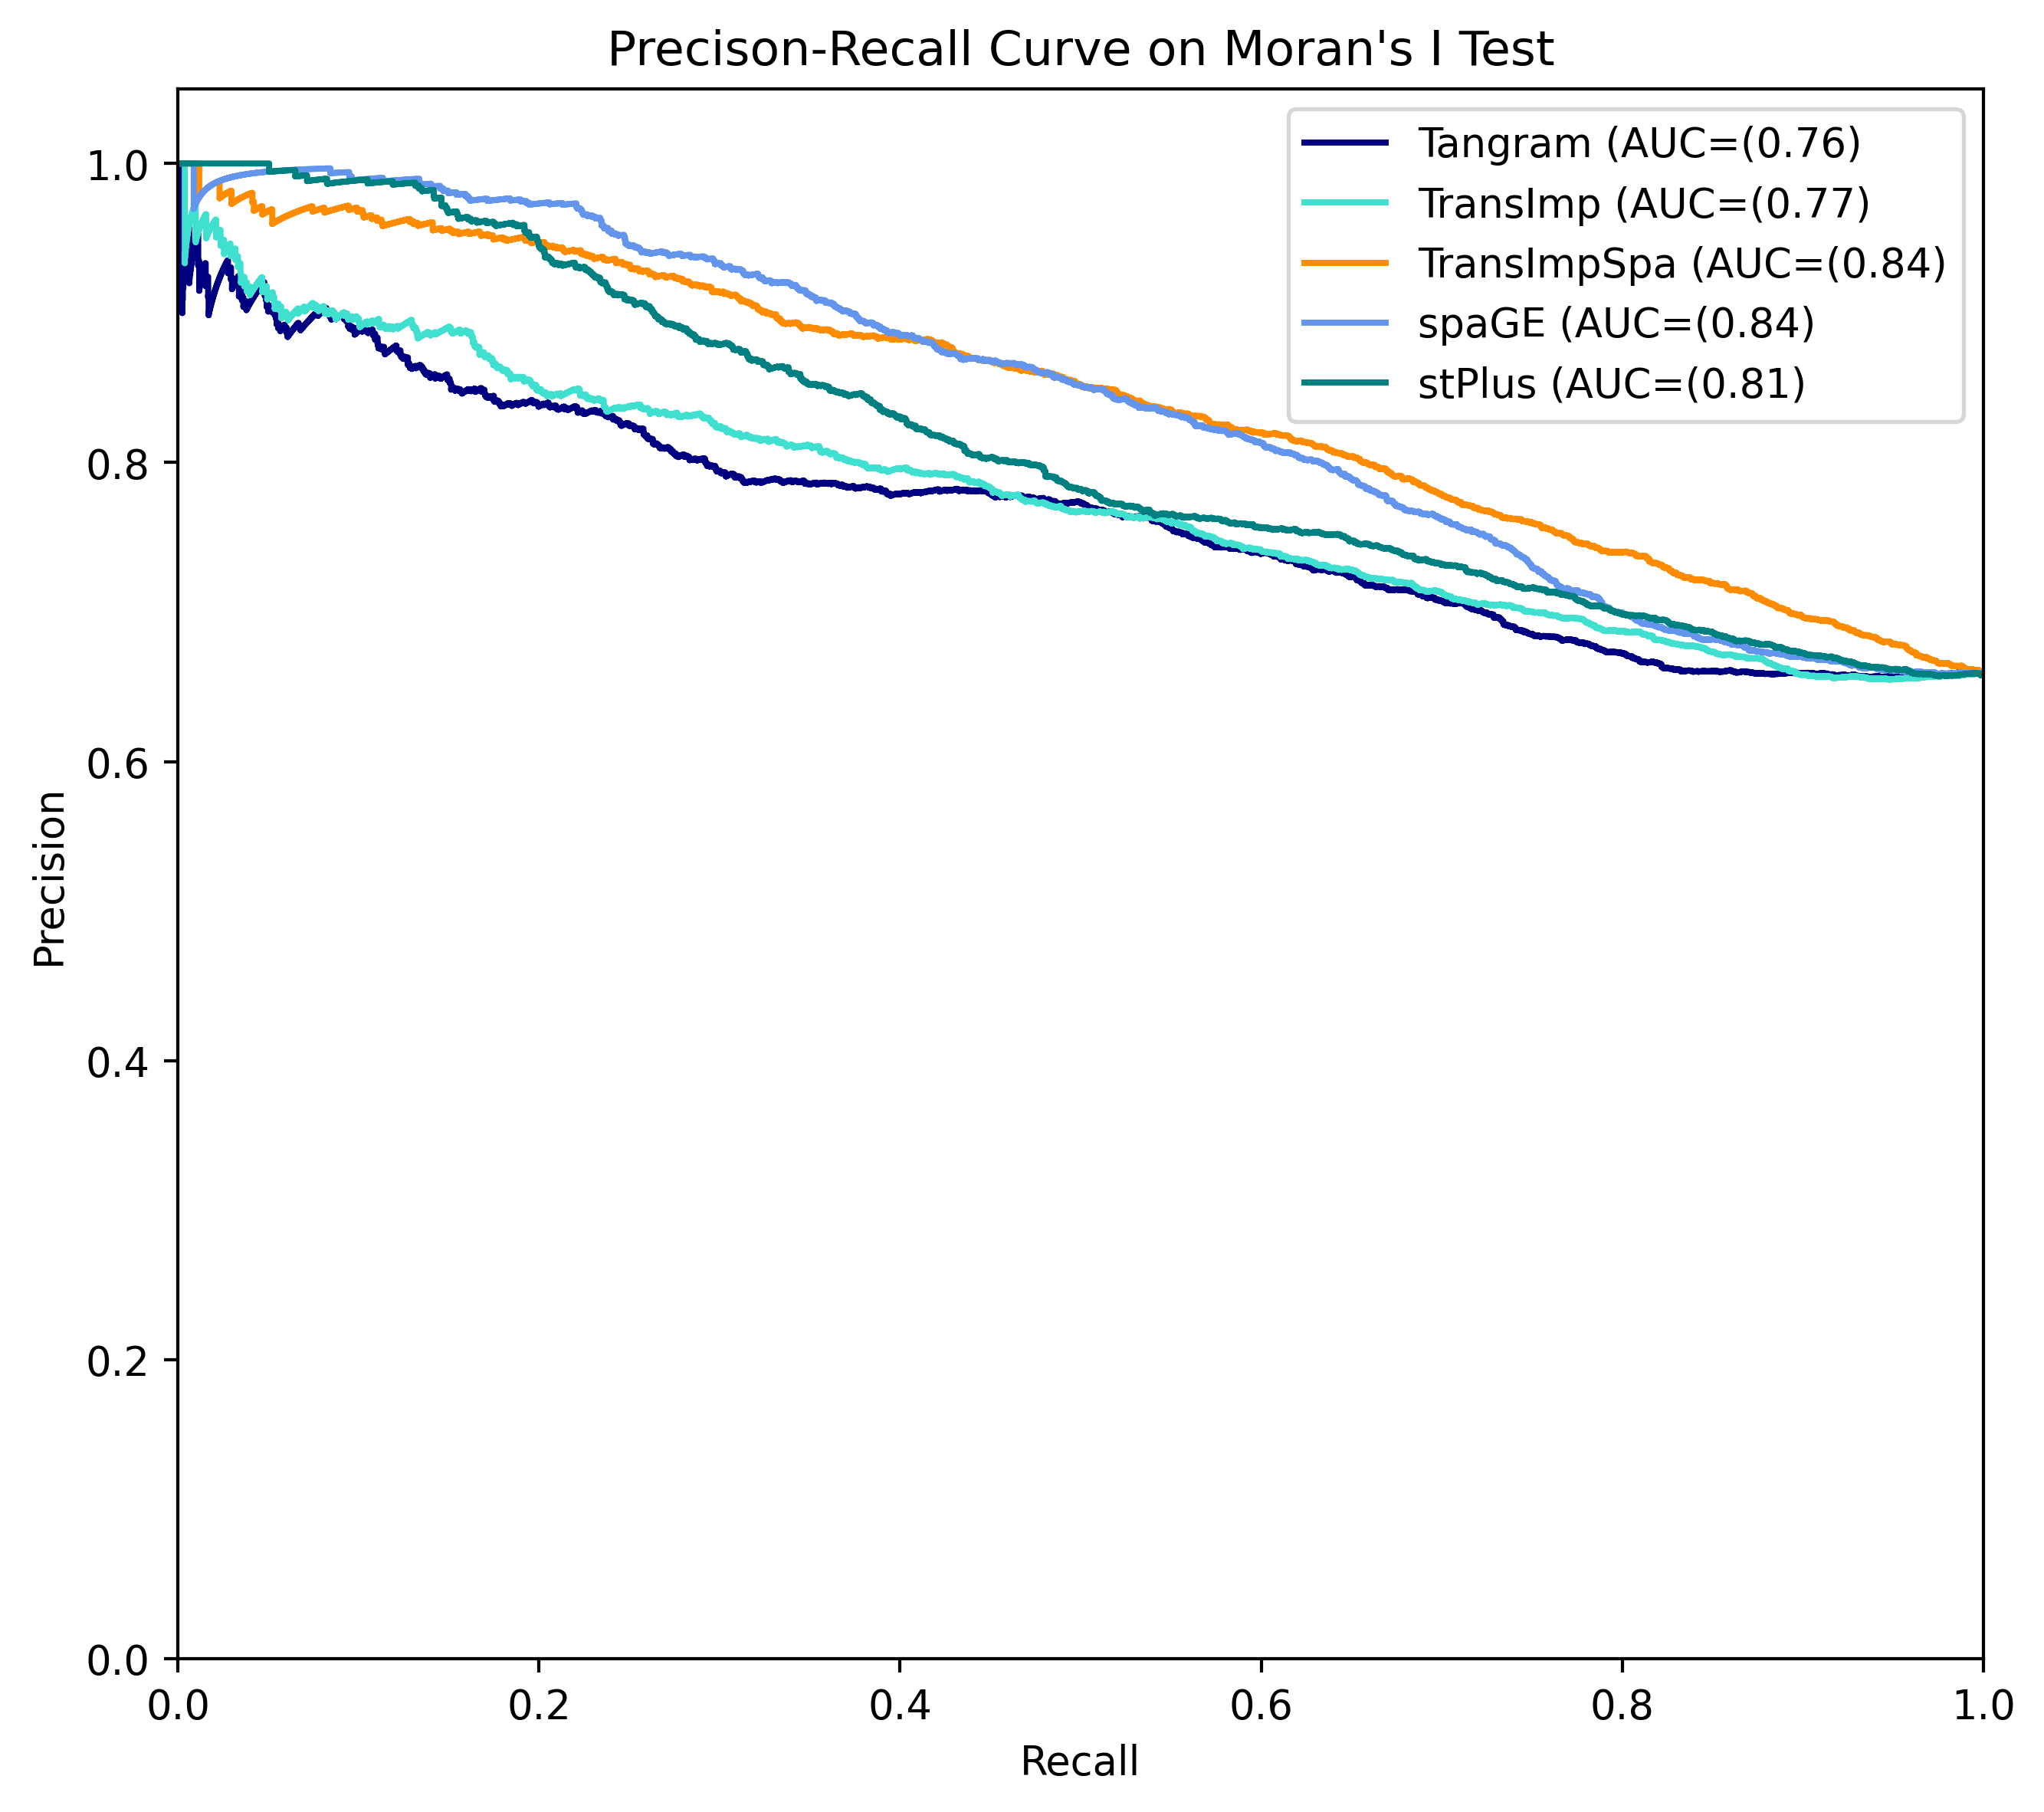

In [12]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, preds_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_fdr[method][sel] + min(df_fdr[method][sel].min()/1e6, 1e-300))
    score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(np.isnan(preds_pval).sum())
    # plt.hist(fdr, bins=100)
    print(method)
    preds = preds_pval < thred
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(truth_pval < thred).sum()}/{truth_pval.shape[0]}), Pred Sig/total ({(preds_pval < thred).sum()}/{preds_pval.shape[0]})')
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpClsSpa", 'truth'}:
        idx += 1
    else:
        continue     
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 5512/6852
Tangram
FPR: 1.000000
(TransImp) Valid genes: 5512/6852
TransImp
FPR: 1.000000
(TransImpSpa) Valid genes: 5512/6852
TransImpSpa
FPR: 0.676251
(spaGE) Valid genes: 5512/6852
spaGE
FPR: 0.973376
(stPlus) Valid genes: 5351/6852
stPlus
FPR: 0.000000


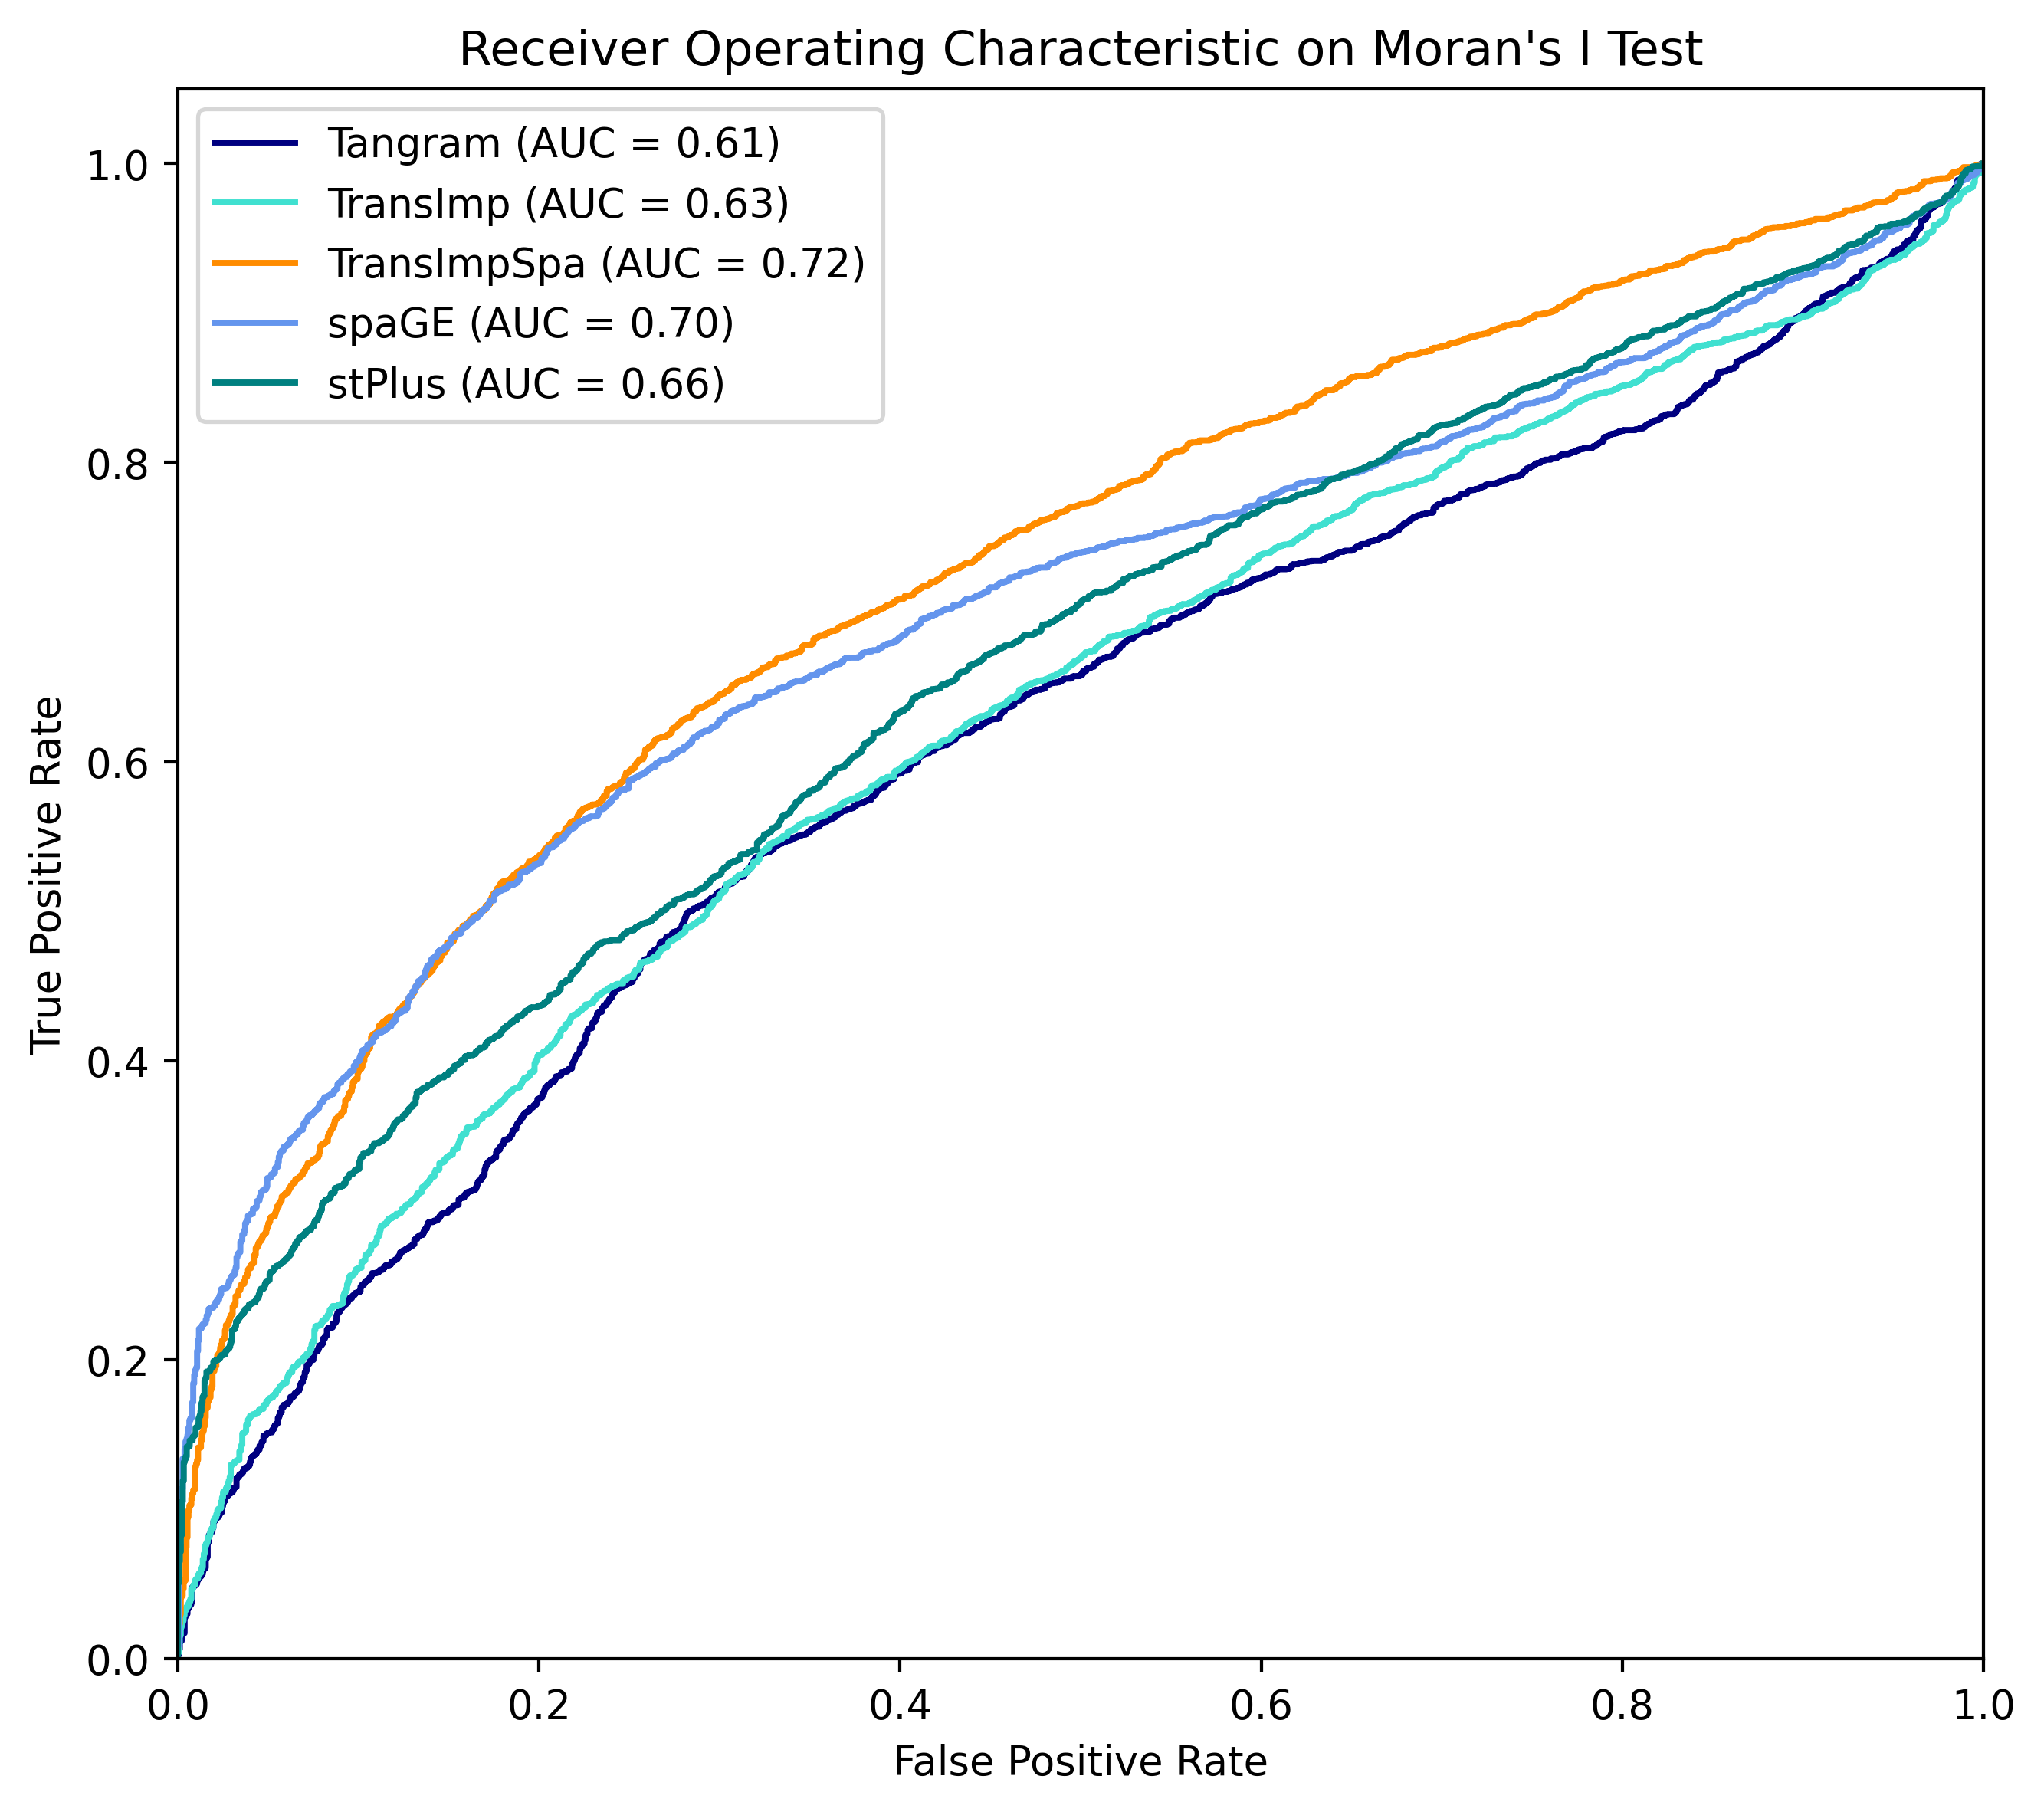

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [13]:
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min()/1e6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(method)
    preds = method_pval < thred
    
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    
    if not method in {"transImpCls", 'truth',  "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    
    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 5512/6852
Tangram
FPR: 1.000000
prec: 0.659288824383164, recl: 1.0,  F1: 0.794664334135141
(TransImp) Valid genes: 5512/6852
TransImp
FPR: 1.000000
prec: 0.659288824383164, recl: 1.0,  F1: 0.794664334135141
(TransImpSpa) Valid genes: 5512/6852
TransImpSpa
FPR: 0.676251
prec: 0.6561061467641484, recl: 0.666758392955421,  F1: 0.6613893817387743
(spaGE) Valid genes: 5512/6852
spaGE
FPR: 0.973376
prec: 0.6637851756483355, recl: 0.9931205283434232,  F1: 0.795722632565318
(stPlus) Valid genes: 5351/6852
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0
(TransImpCls) Valid genes: 5512/6852
TransImpCls
FPR: 1.000000
prec: 0.659288824383164, recl: 1.0,  F1: 0.794664334135141
(TransImpClsSpa) Valid genes: 5512/6852
TransImpClsSpa
FPR: 0.876464
prec: 0.6686795491143317, recl: 0.9141441937259218,  F1: 0.7723785166240409


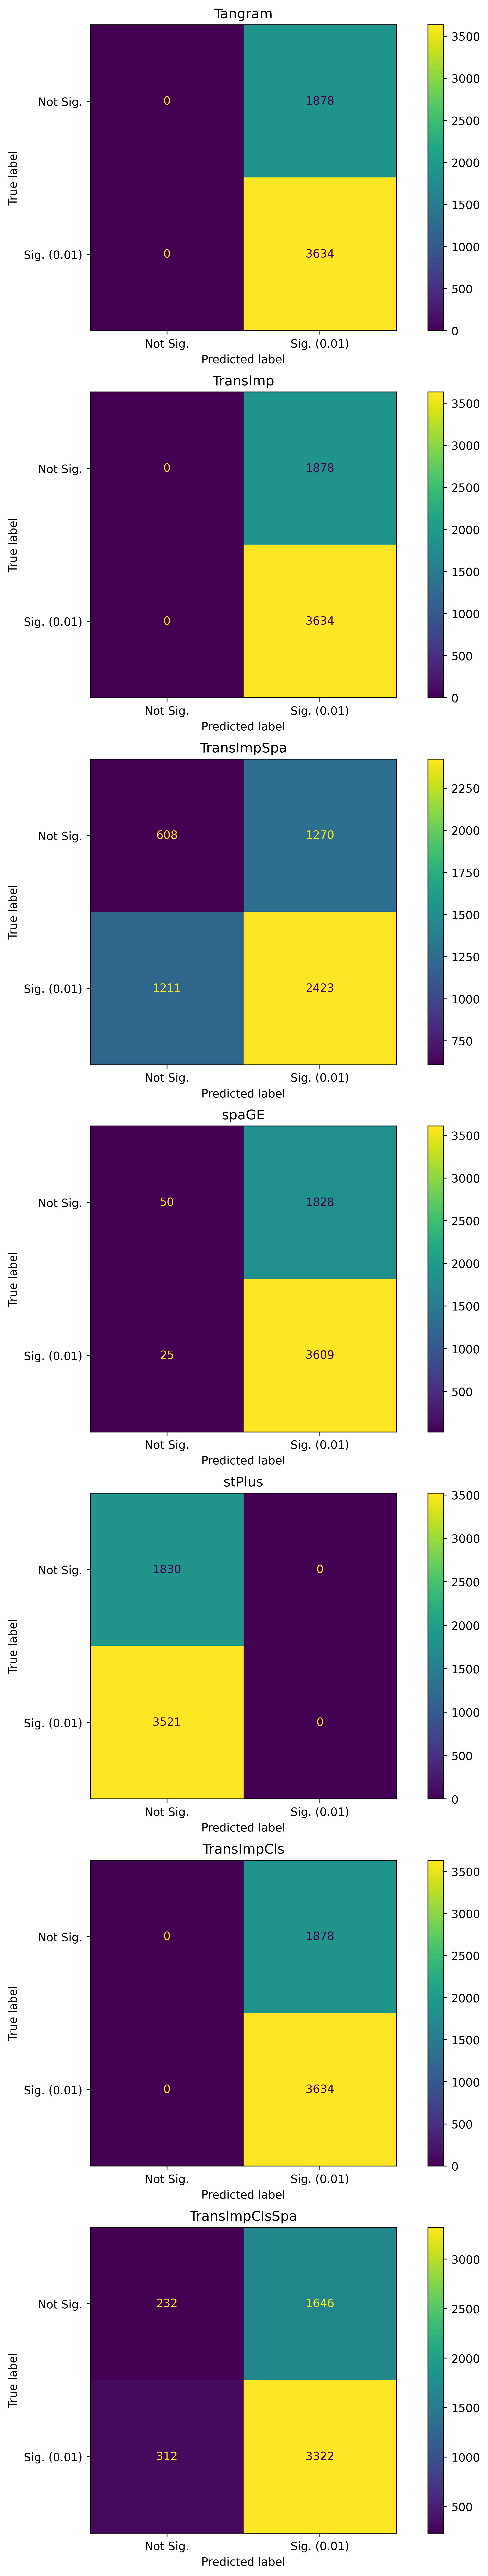

In [14]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in methods:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, pred_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    # score = df_I[method][sel]
    
    print(method)
    preds = pred_pval < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [15]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r intestine5fold

[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2649 
## number of total genes: 6852 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2649 
## number of total genes: 6581 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing Wi

In [16]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

truth
Tangram
TransImp
TransImpSpa
spaGE
stPlus
TransImpCls
TransImpClsSpa


(               truth        Tangram       TransImp   TransImpSpa  \
 A1BG    1.681943e-03   1.998401e-14   7.791989e-12  4.976239e-04   
 A1CF    7.588516e-07  2.016928e-103   2.056538e-93  8.480052e-42   
 AADAT   5.211543e-01   1.398547e-25   8.113365e-20  1.355478e-08   
 AAED1   6.643790e-01   1.489586e-37   7.124114e-29  2.277964e-04   
 AASDH   2.388437e-01   6.590573e-32   3.825380e-20  3.255981e-09   
 ...              ...            ...            ...           ...   
 ZSWIM1  2.453267e-01   1.019096e-61   3.594575e-60  3.146197e-16   
 ZSWIM4  2.986566e-01   6.257491e-30   1.483973e-21  1.175648e-11   
 ZXDB    6.283649e-01   1.612054e-24   5.049430e-34  5.324630e-13   
 ZYX     4.150341e-08   1.180555e-30   3.674258e-43  2.762821e-10   
 ZZEF1   2.020606e-14   8.491894e-96  1.862524e-109  2.330014e-50   
 
                spaGE        stPlus    TransImpCls  TransImpClsSpa  
 A1BG    2.092161e-02  1.000000e+00   4.773959e-15    4.108163e-05  
 A1CF    1.446735e-99  4.596904e

(Tangram) Valid genes: 6852/6852
Tangram
FPR: 0.998244
(TransImp) Valid genes: 6852/6852
TransImp
FPR: 0.999781
(TransImpSpa) Valid genes: 6852/6852
TransImpSpa
FPR: 0.828176
(spaGE) Valid genes: 6852/6852
spaGE
FPR: 0.897520
(stPlus) Valid genes: 6852/6852
stPlus
FPR: 0.880404


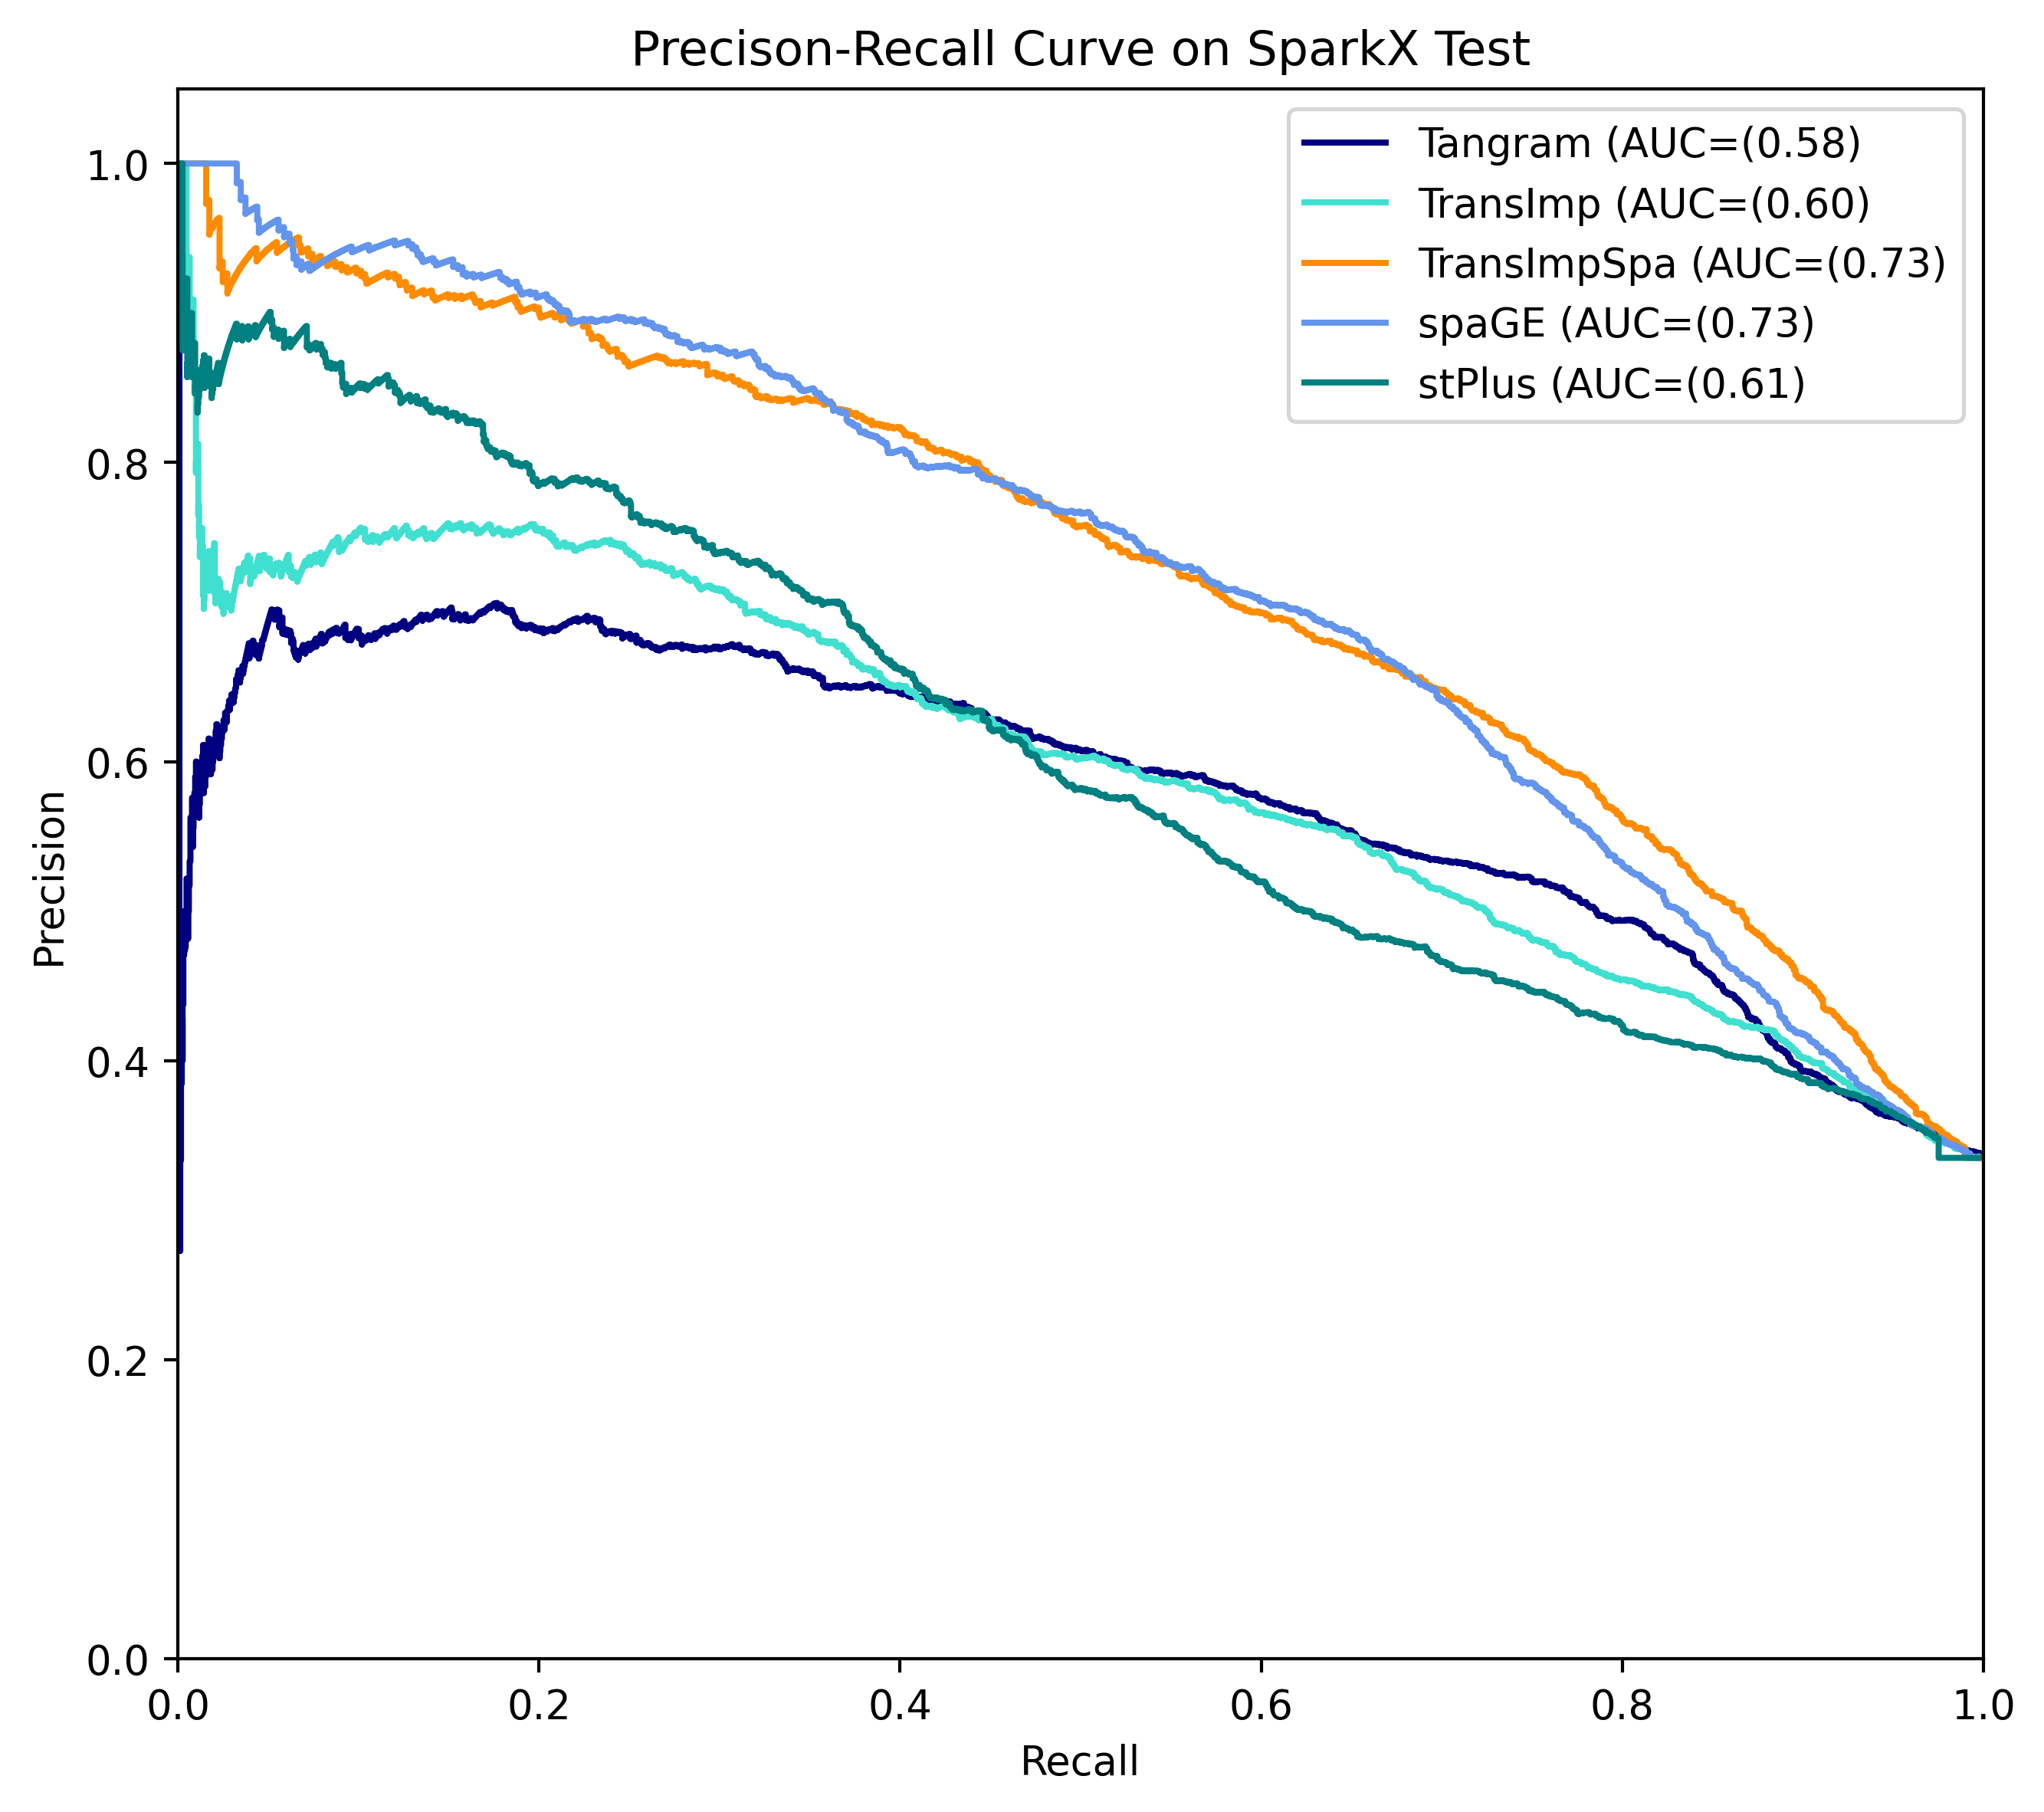

In [17]:
from sklearn import metrics
from matplotlib import pyplot as plt

thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
    
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
       
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 6852/6852
Tangram
FPR: 0.998244
(TransImp) Valid genes: 6852/6852
TransImp
FPR: 0.999781
(TransImpSpa) Valid genes: 6852/6852
TransImpSpa
FPR: 0.828176
(spaGE) Valid genes: 6852/6852
spaGE
FPR: 0.897520
(stPlus) Valid genes: 6852/6852
stPlus
FPR: 0.880404


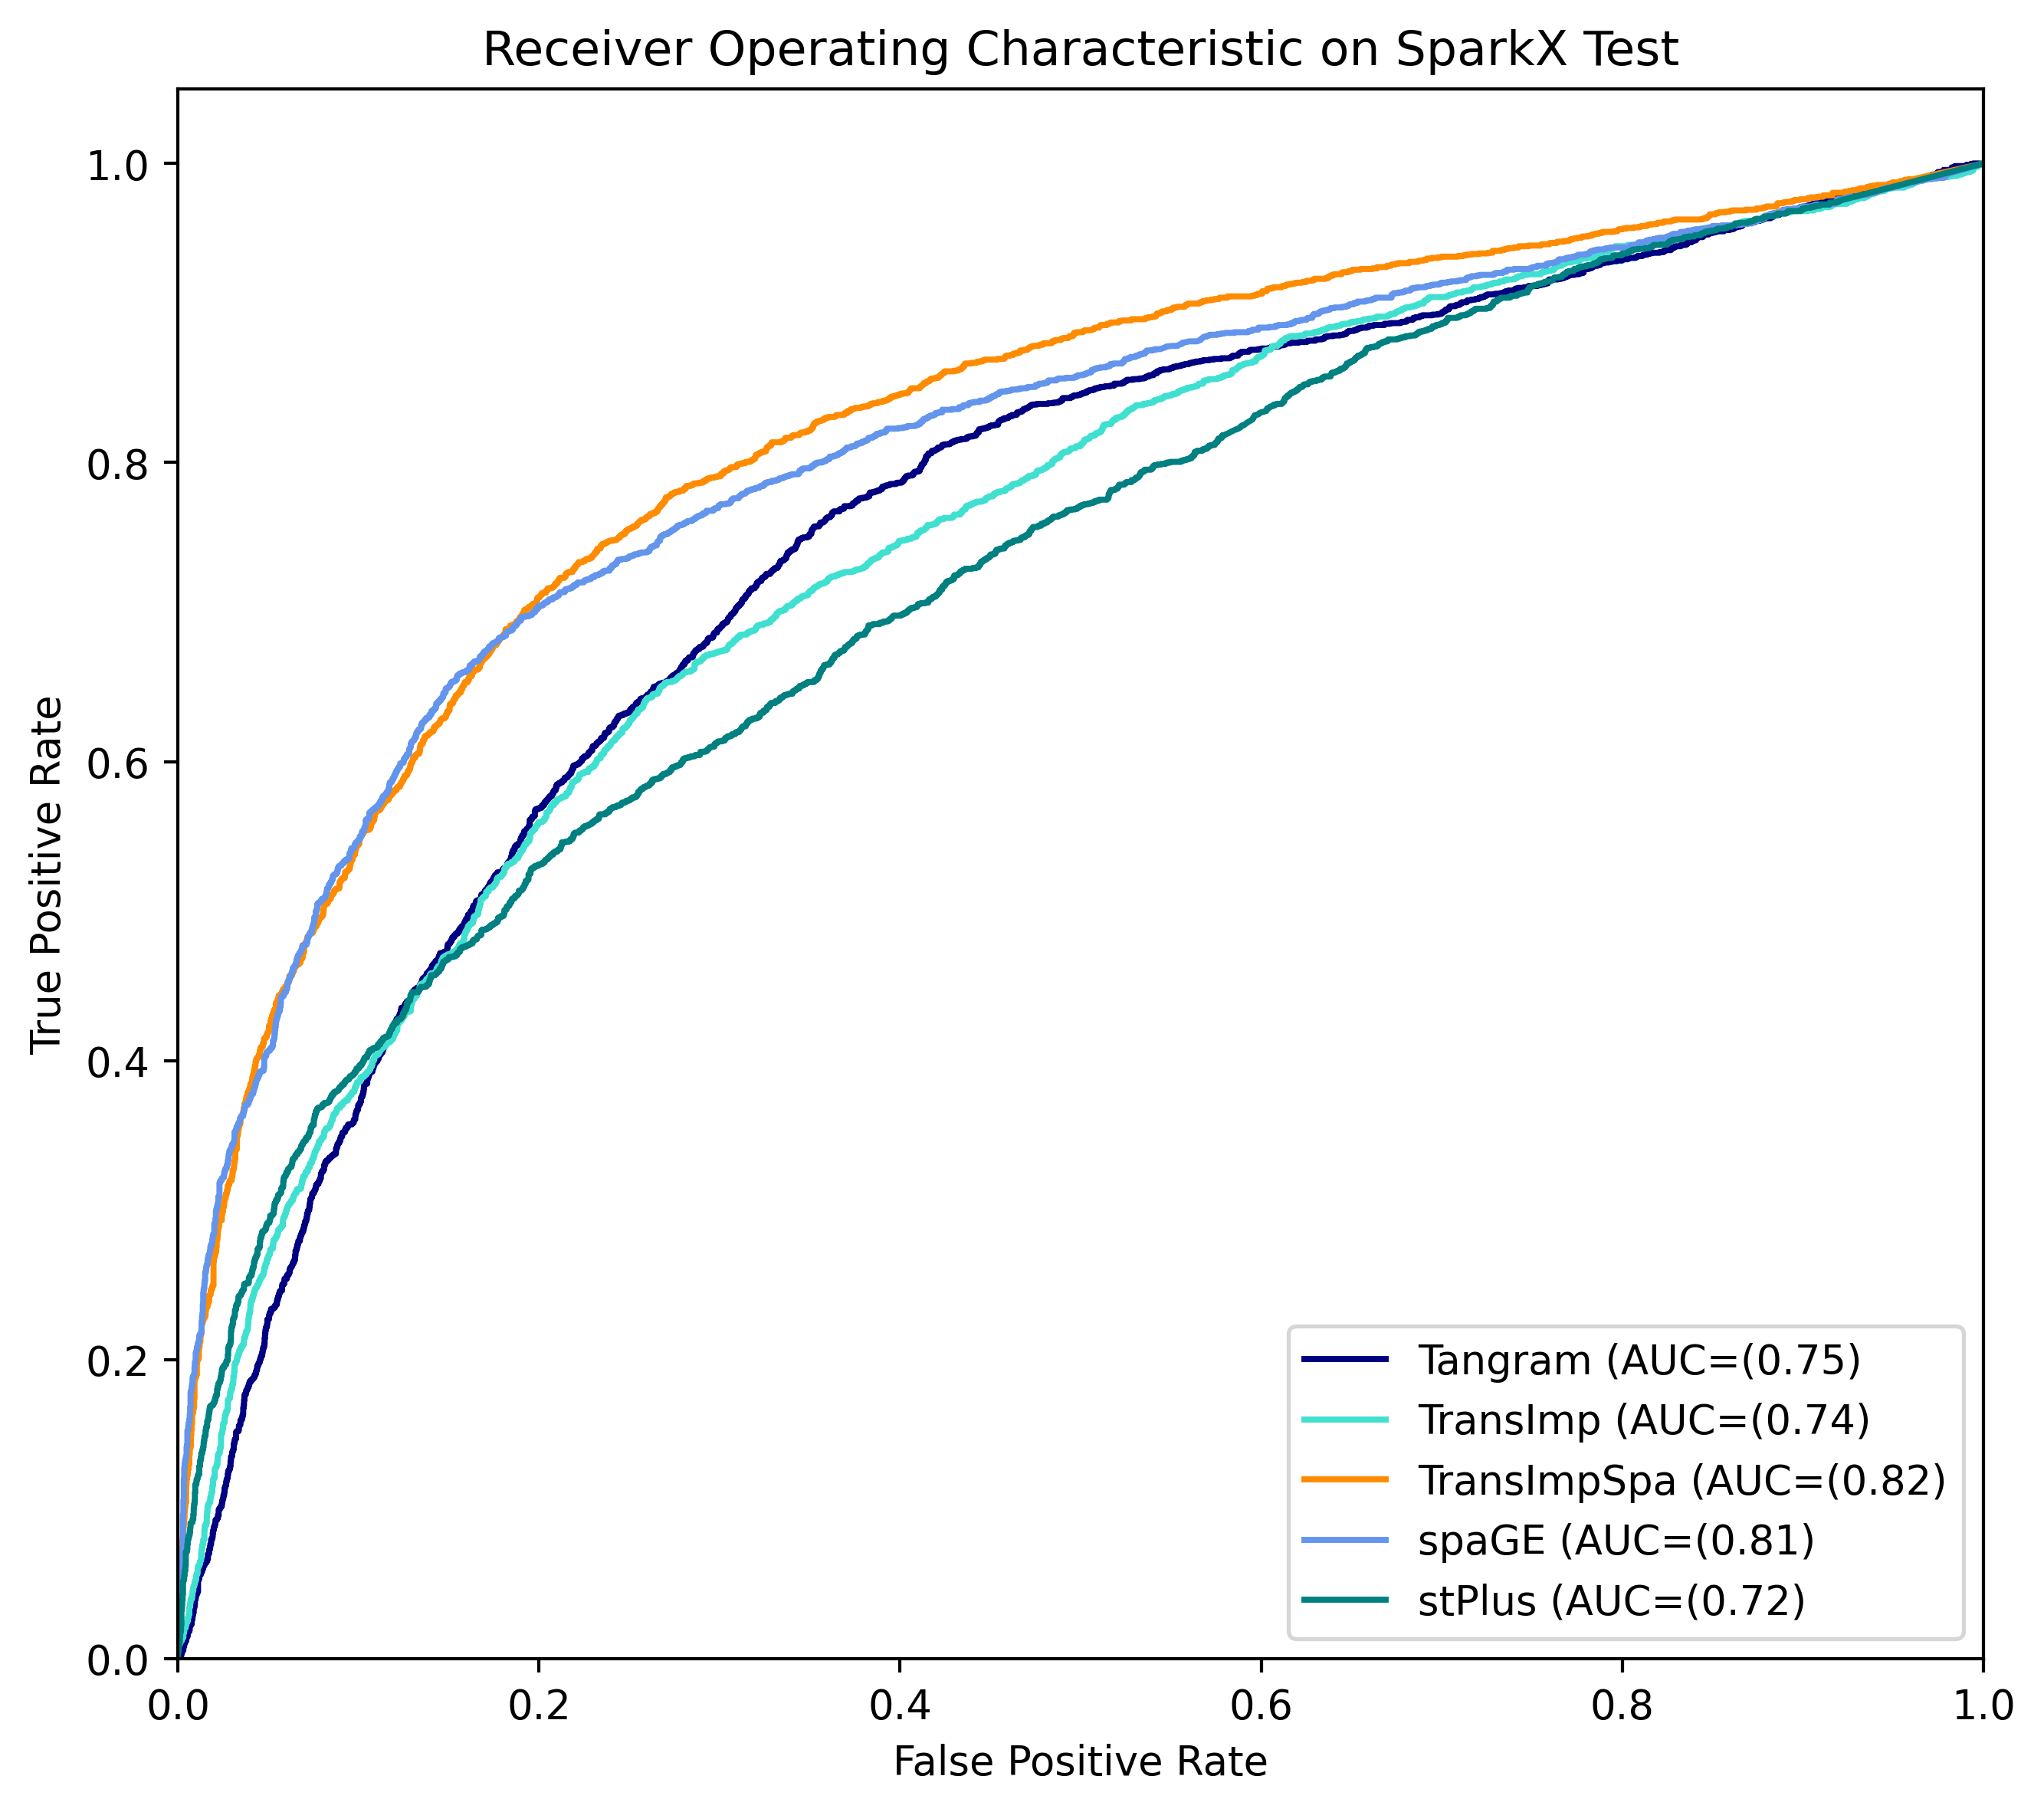

In [18]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-500))
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 6852/6852
Tangram
FPR: 0.998244
prec: 0.3353302162478083, recl: 1.0,  F1: 0.5022431338220812
(TransImp) Valid genes: 6852/6852
TransImp
FPR: 0.999781
prec: 0.3349875930521092, recl: 1.0,  F1: 0.5018587360594796
(TransImpCls) Valid genes: 6852/6852
TransImpCls
FPR: 0.999781
prec: 0.3349875930521092, recl: 1.0,  F1: 0.5018587360594796
(TransImpClsSpa) Valid genes: 6852/6852
TransImpClsSpa
FPR: 0.983761
prec: 0.33761820330969267, recl: 0.9956427015250545,  F1: 0.5042480414873662
(TransImpSpa) Valid genes: 6852/6852
TransImpSpa
FPR: 0.828176
prec: 0.3691073219658977, recl: 0.9620915032679739,  F1: 0.533526640086988
(spaGE) Valid genes: 6852/6852
spaGE
FPR: 0.897520
prec: 0.3525407630204211, recl: 0.9703703703703703,  F1: 0.5171853228053879
(stPlus) Valid genes: 6852/6852
stPlus
FPR: 0.880404
prec: 0.35560552521683264, recl: 0.9647058823529412,  F1: 0.5196573172162893


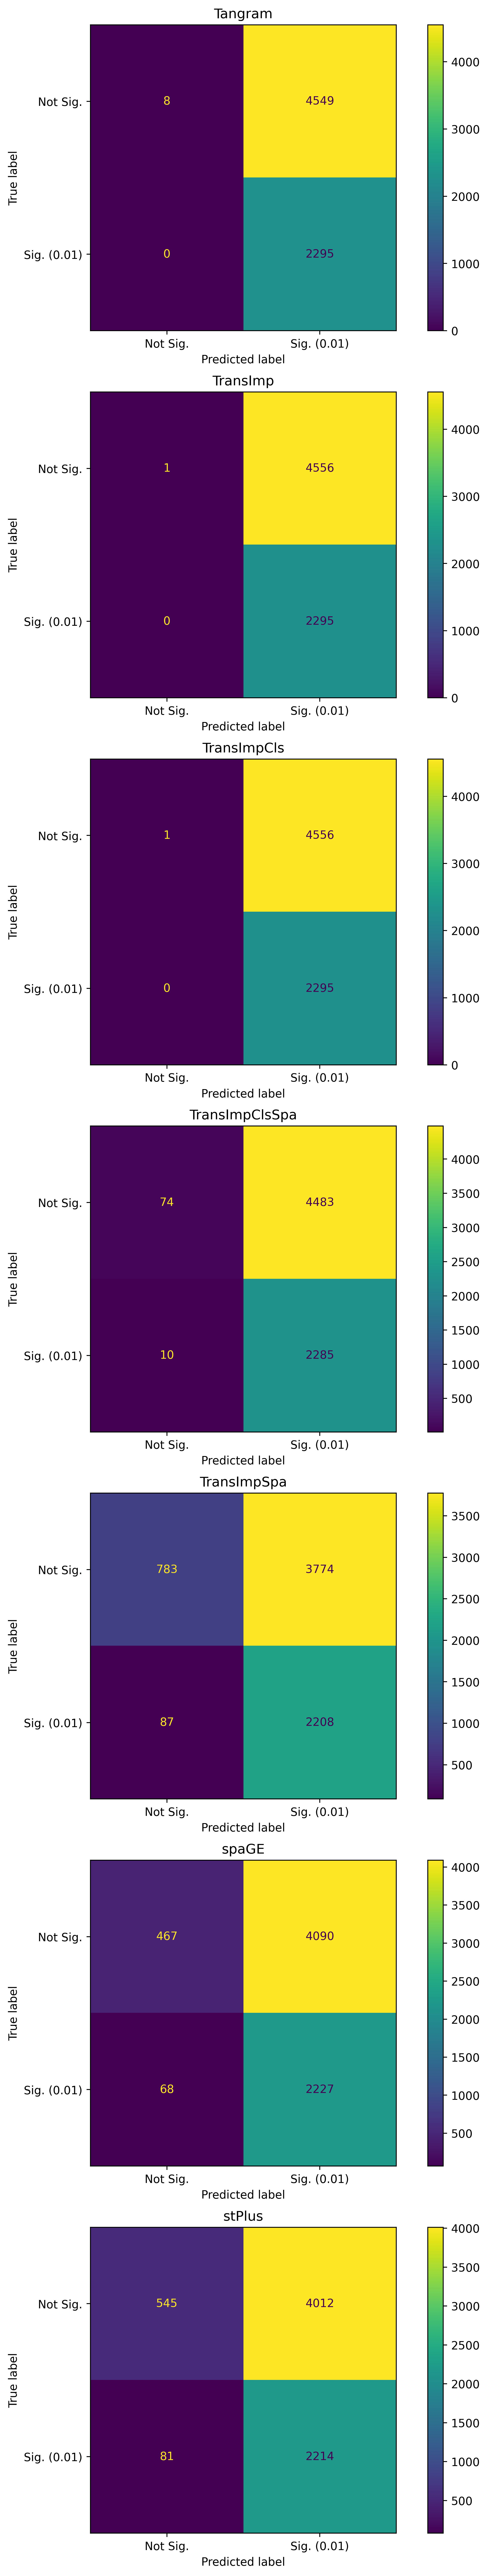

In [19]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [20]:
from scipy import sparse
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
def read_data(imp_adatas):
    spa_adata = sc.read_h5ad("../../data/ST/intest/A1.h5ad")
    spa_adata.obsm['spatial'] = spa_adata.obsm['spatial'][['x','y']].values
    adatas = {}
    for method in methods:
        adatas[method] = merge_data(imp_adatas[method], spa_adata)
        adatas[method].obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    return adatas

m_adatas = read_data(dict_adata)

Valid genes: 26686, Ex genes: 6852
Valid genes: 26686, Ex genes: 6852
Valid genes: 26686, Ex genes: 6852
Valid genes: 26686, Ex genes: 6852
Valid genes: 26686, Ex genes: 6852
Valid genes: 26686, Ex genes: 6852
Valid genes: 26686, Ex genes: 6852
Valid genes: 26686, Ex genes: 6852


In [21]:
def spatialdm(adata, spec, l):
    sdm.weight_matrix(adata,  n_nearest_neighbors=6, l=l, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=0)
    # global Moran selection
    # print(adata.uns)
    # print(adata)
    cp_adata = None
    try:
        sdm.spatialdm_global(adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)        
    except Exception as e:
        # print(e)
        cp_adata = adata.copy()
        sdm.extract_lr(cp_adata, spec, min_cell=1)
        sdm.spatialdm_global(cp_adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(cp_adata, method='z-score', fdr=True, threshold=0.1)
    # select significant pairs
    if not cp_adata is None:
        full_set = adata.uns['geneInter'].interaction_name
        # print(np.intersect1d(full_set, cp_adata.uns['global_res'].index.values))
        full_global_res = cp_adata.uns['global_res'].copy()
        full_global_res['global_I'] = cp_adata.uns['global_I'].copy()
        for pair in full_set:
            if pair not in cp_adata.uns['global_res'].index.values:
                # z	perm_pval	fdr	selected
                full_global_res = pd.concat([full_global_res, pd.DataFrame({
                    "Ligand0":{pair:pair.split("_")[0]},
                    "Receptor0":{pair:pair.split("_")[1]},
                    "Receptor1":{pair:None},
                    "z_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "z":{pair:np.random.rand()*0.01},
                    "perm_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "fdr":{pair:0.99 + np.random.rand() * 0.01},
                    "selected":{pair:False},
                    "global_I":{pair:np.random.rand() * 1e-6},
                })])
        # print(np.intersect1d(full_global_res.index, cp_adata.uns['global_res'].index.values))        
        adata.uns['global_res'] = full_global_res.loc[adata.uns['geneInter'].interaction_name].copy()
        adata.uns['global_I'] = full_global_res.global_I.values
        
        
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    print(adata.uns['global_res'].shape)
for md in m_adatas:
    spatialdm(m_adatas[md], spec, 75)    

100%|██████████| 10/10 [00:01<00:00,  9.12it/s]


1927 1927
(1903, 13)


100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


1927 1927
(1903, 13)


100%|██████████| 10/10 [00:01<00:00,  8.83it/s]


1927 1927
(1903, 13)


100%|██████████| 10/10 [00:01<00:00,  9.12it/s]


1927 1927
(1903, 13)


100%|██████████| 10/10 [00:01<00:00,  8.91it/s]


1927 1927
(1903, 13)


100%|██████████| 10/10 [00:01<00:00,  9.44it/s]


1927 1927
(1903, 13)


100%|██████████| 10/10 [00:01<00:00,  8.89it/s]


1927 1927
(1903, 13)


100%|██████████| 10/10 [00:01<00:00,  8.86it/s]


1927 1927
(1903, 13)


In [22]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(m_adatas, outfile)

Tangram # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 659
TransImp # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 697
TransImpSpa # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 524
spaGE # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 384
stPlus # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 313
TransImpCls # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 511
TransImpClsSpa # 1396 pairs, # sig pairs: (Truth): 282, (Preds) 523


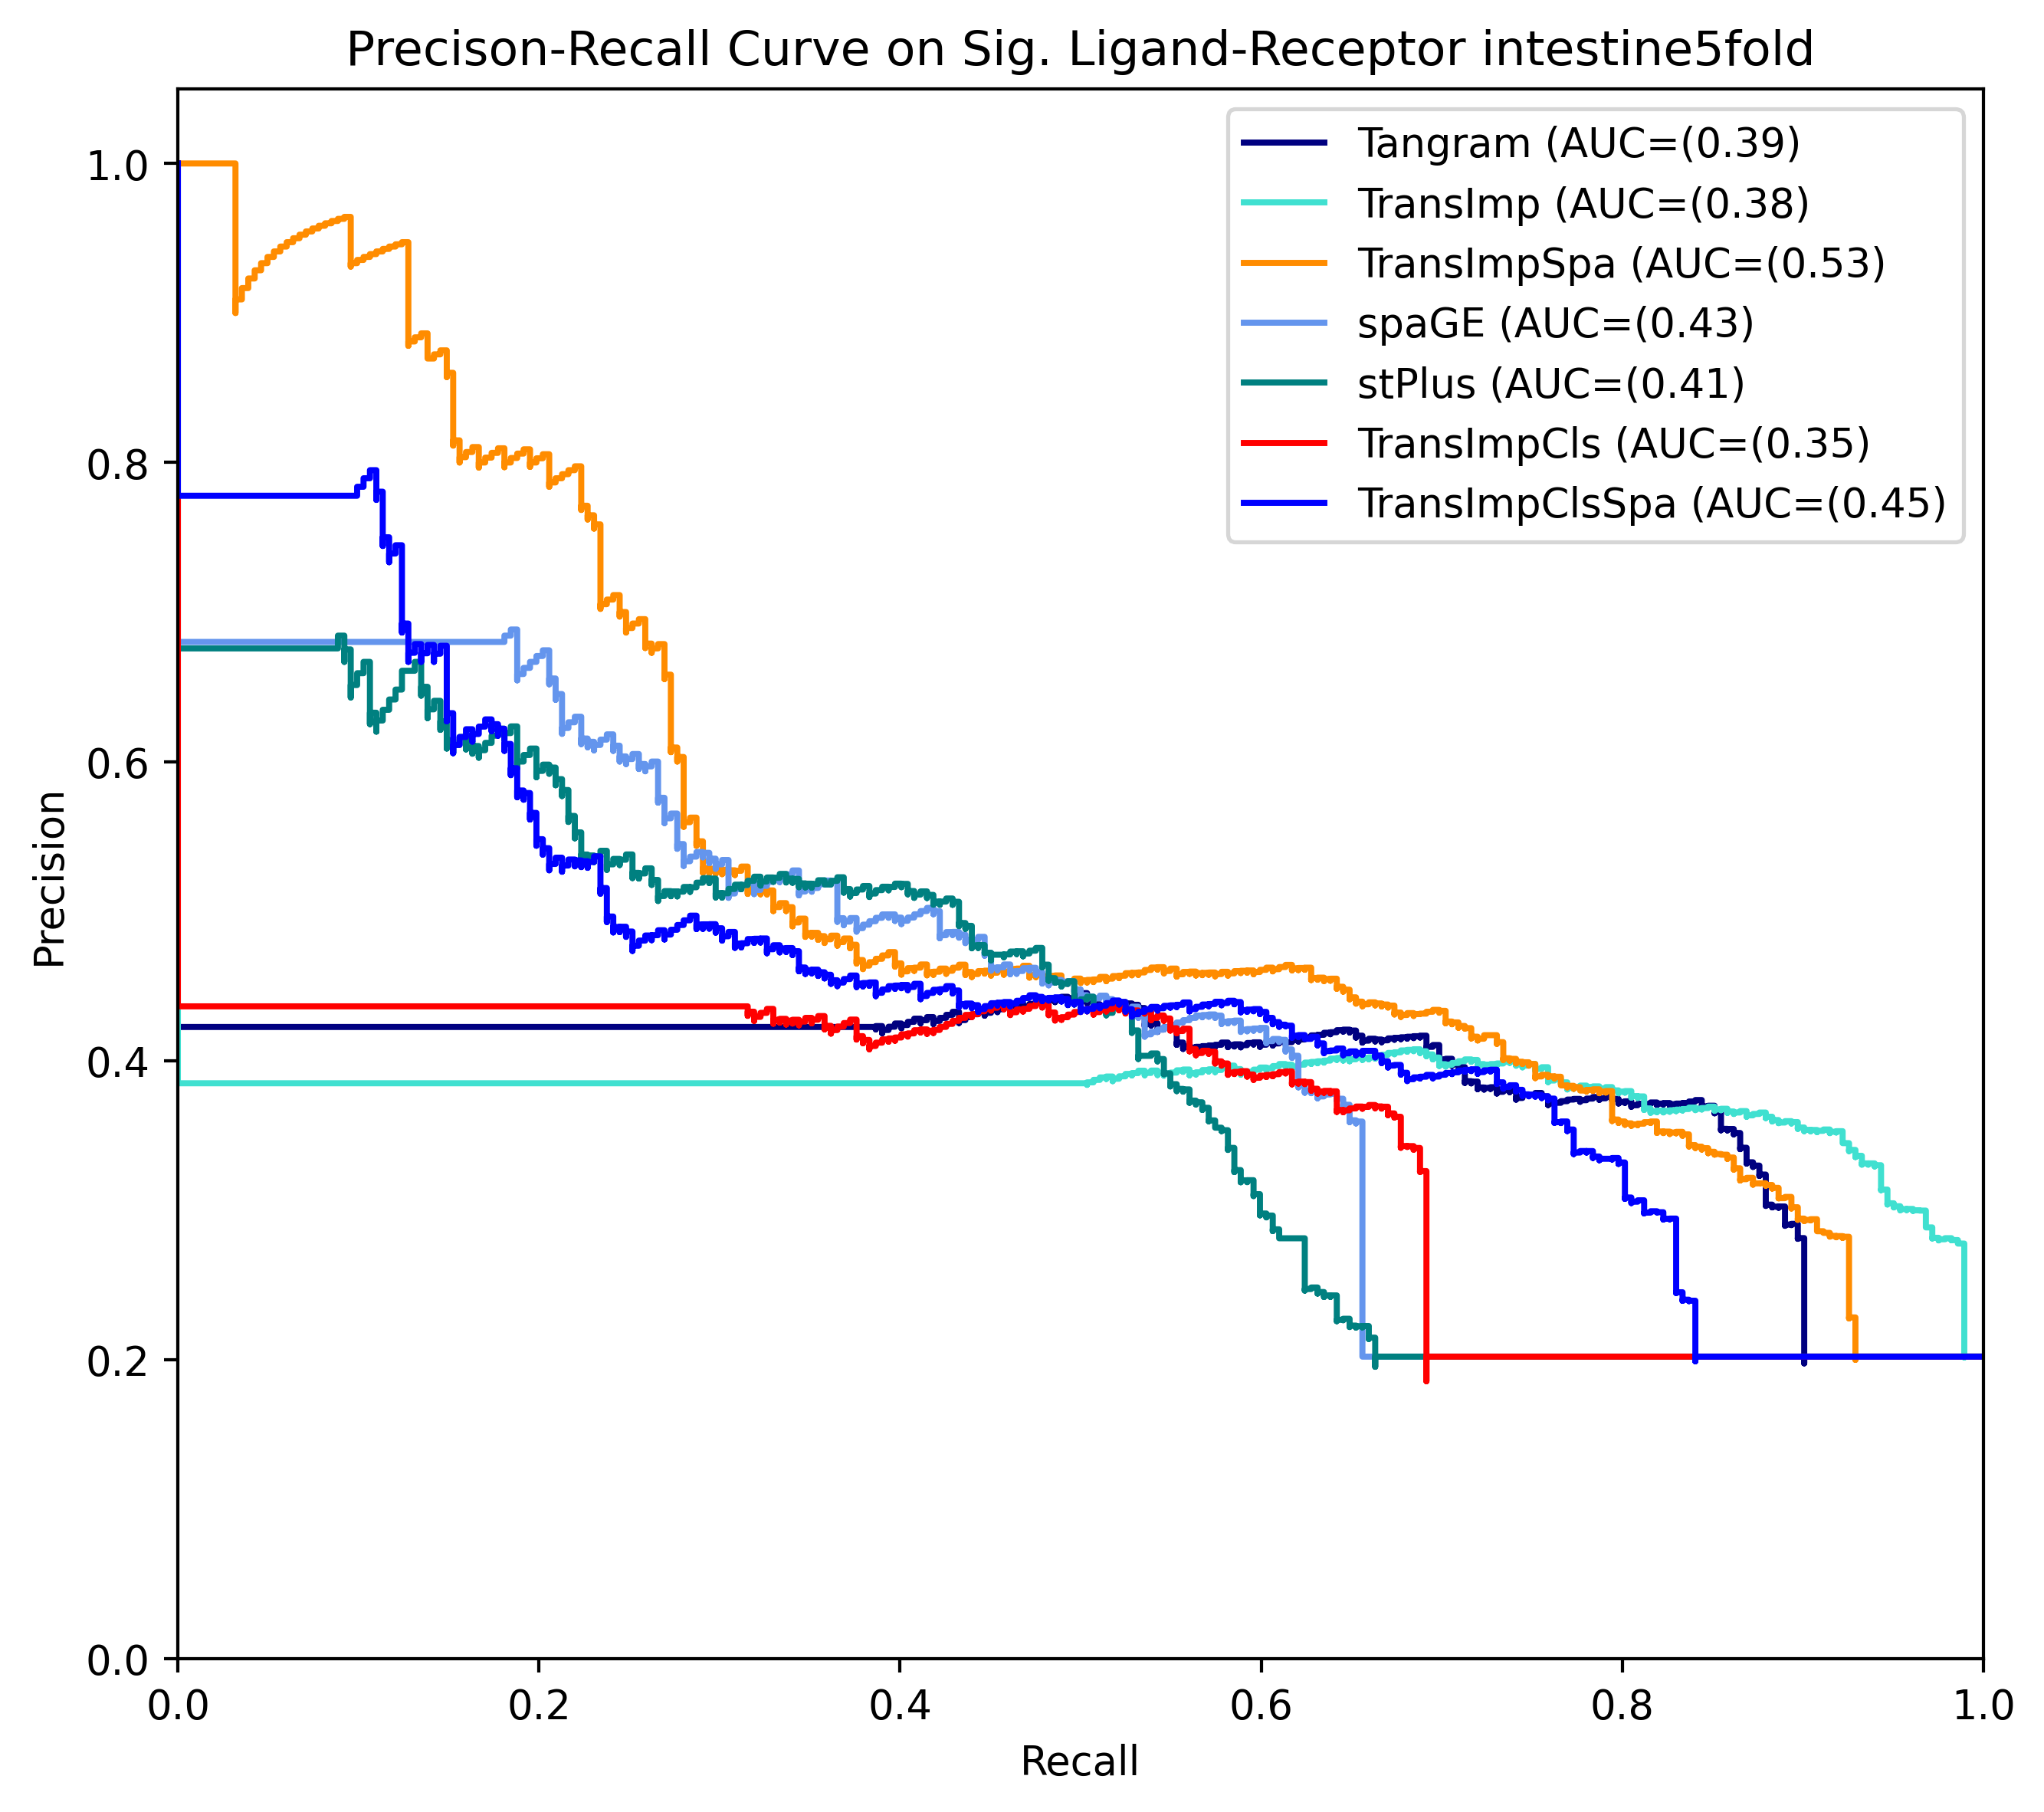

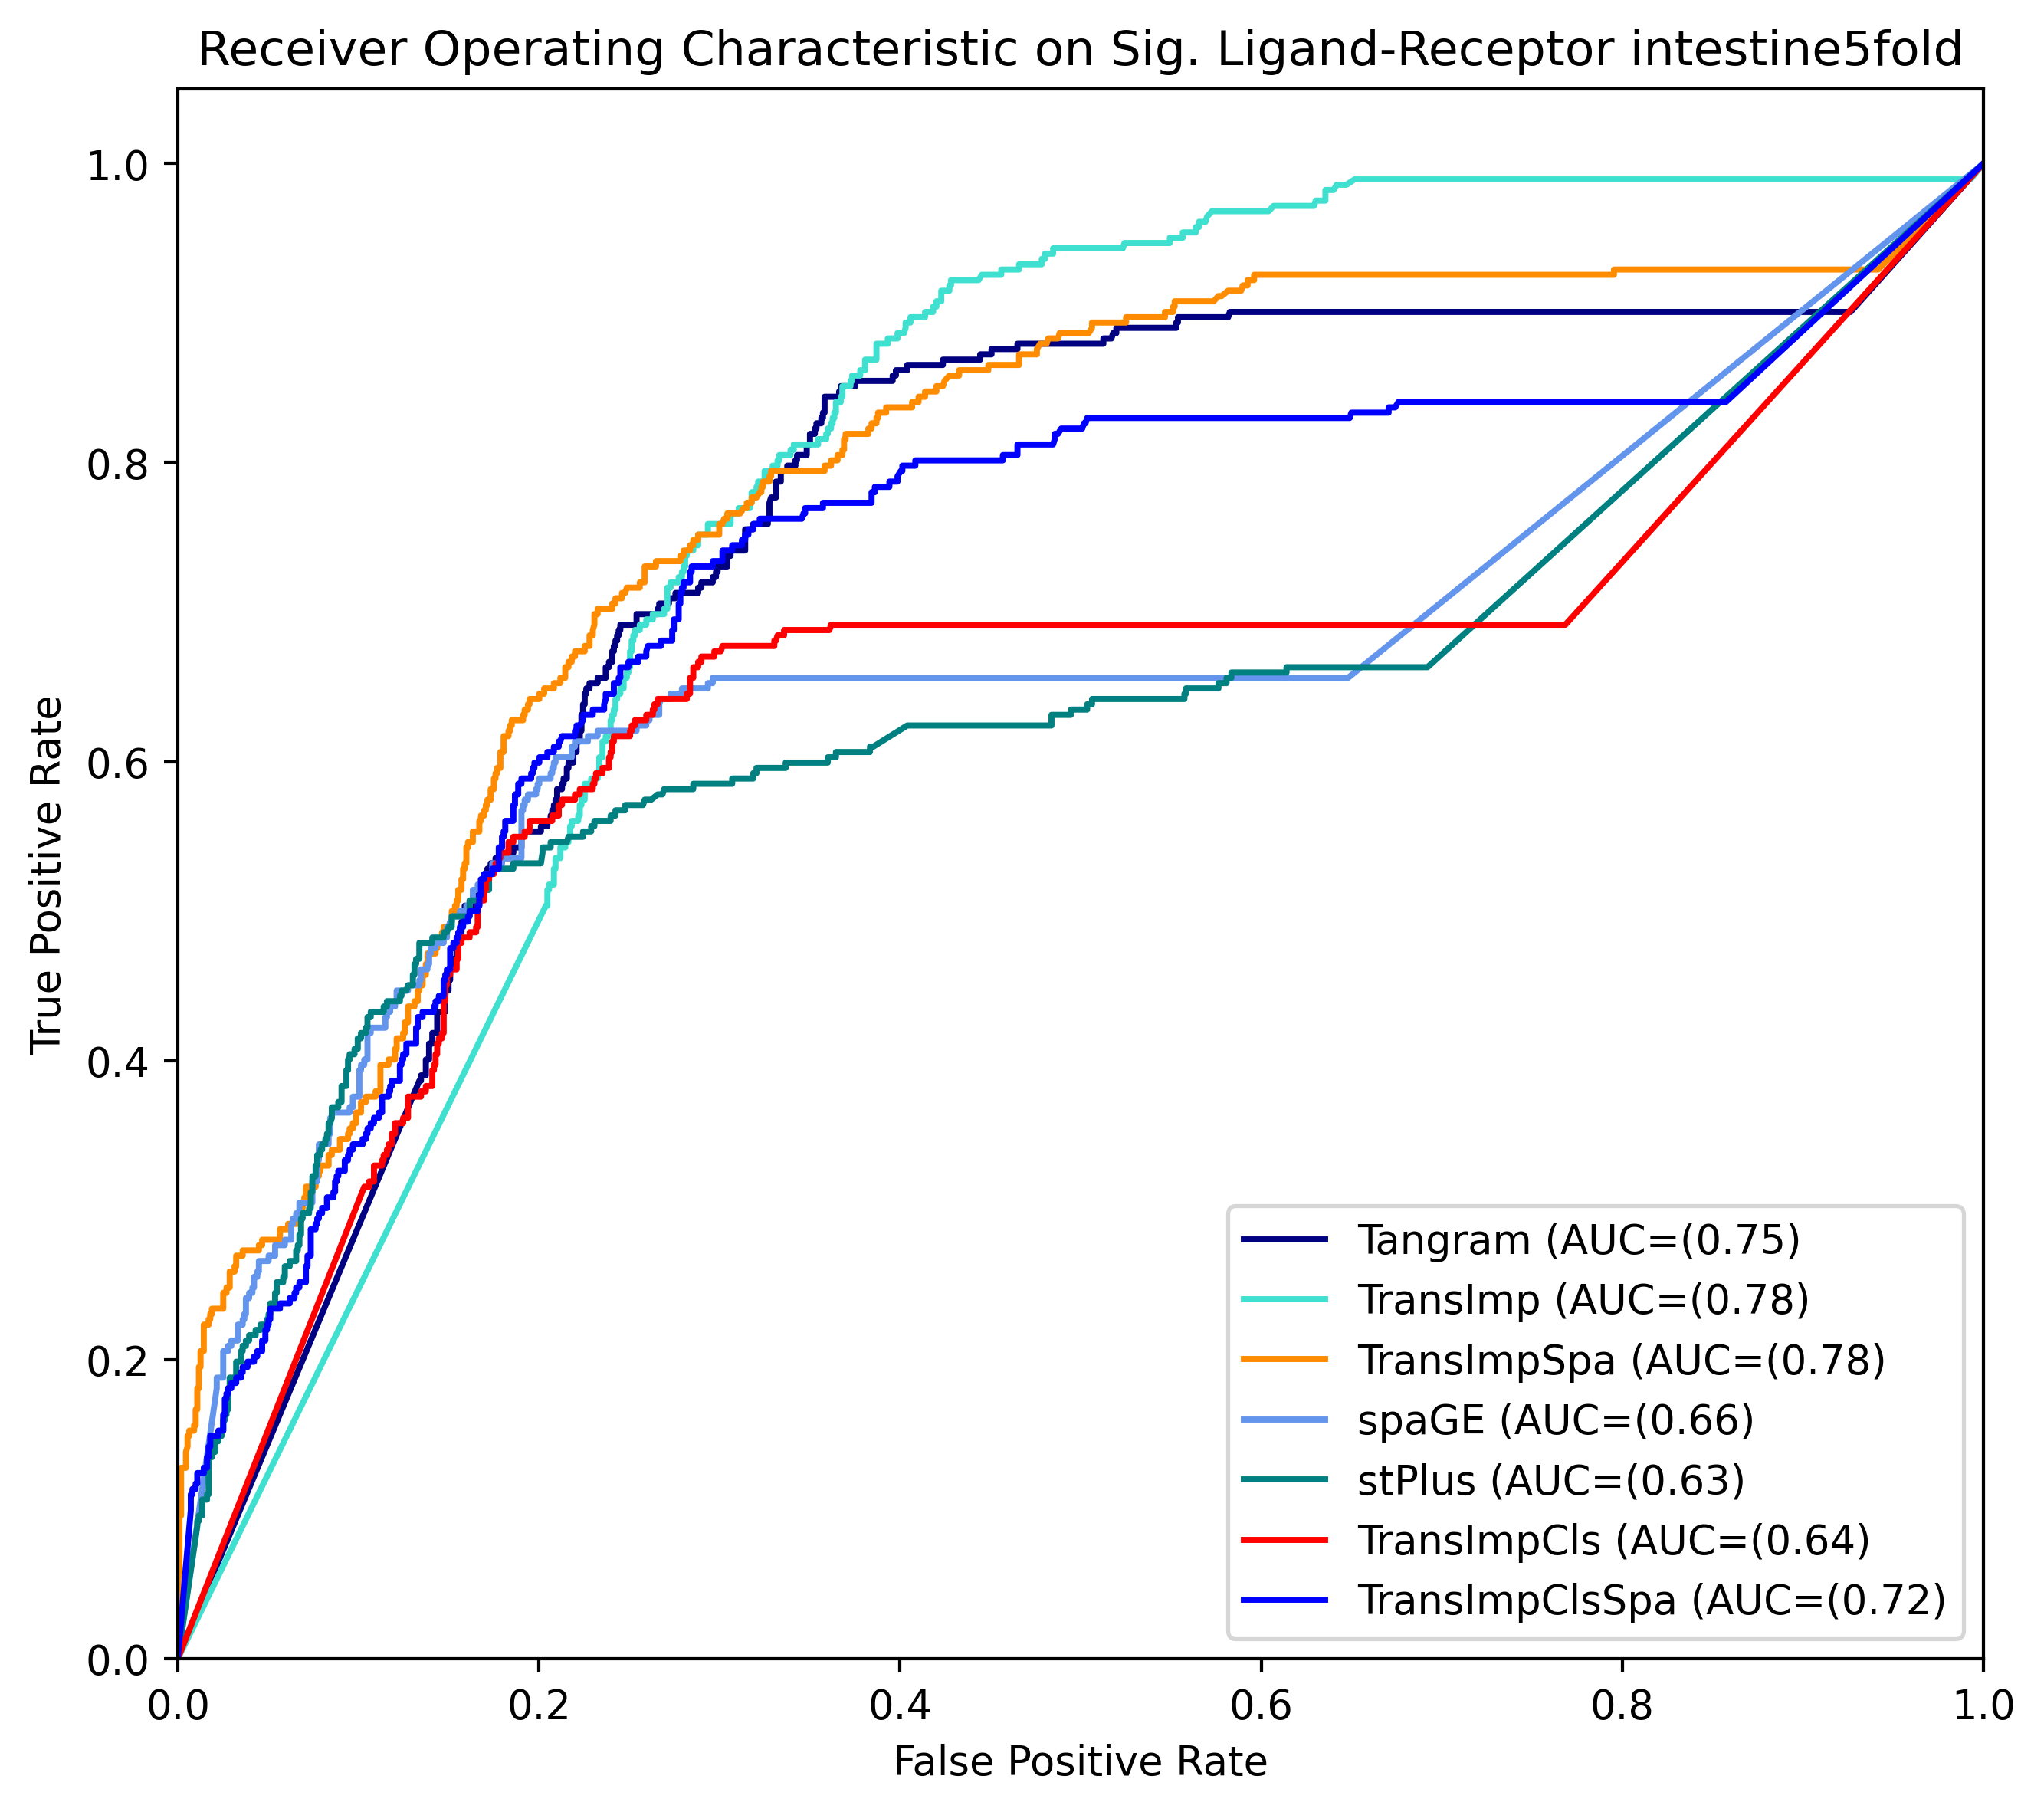

In [23]:
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        print(f"{md} # {len(genes)} pairs, # sig pairs: (Truth): {truth_res.loc[genes].selected.values.sum()}, (Preds) {adatas[md].uns['global_res'].loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(adatas[md].uns['global_res'].loc[genes].fdr.values)
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # plt.hist(score, bins=100);plt.show()
        # score = expit(score)
        # plt.hist(score, bins=100)
        # plt.show()
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # score = expit(score)
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    

precision_recall_curve(m_adatas, ST_name)
roc_curve(m_adatas, ST_name)
